In [1]:
# Cell 1: Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Let's build a portfolio with MSFT, AMZN, GOOGL
stocks = input('Ticker: ').split()  # Input is tickers of stocks
weights = np.array(input('Weights: ').split(), dtype=float)  # You can type in weights based on your portfolio
if weights.size == 0:
    weights = np.random.random(len(stocks))  # Or you can continue with random weights
    weights /= np.sum(weights)
    weights = np.around(weights, 2)

In [5]:
def GetData(stock, time):  # Downloads historical stock prices from yahoofinance and does basic statistical calculations
    hist = yf.download(tickers=stock, period=time, interval='1d', auto_adjust=True, ignore_tz=True)['Close']
    hozam = np.log(hist / hist.shift(1)).dropna()  # Daily log returns
    meanreturn = hozam.mean()
    covmatrix = hozam.cov()  # Covariance matrix
    Returns = np.log((hist.tail(1).iloc[0] - hist.head(1).iloc[0]) / hist.head(1).iloc[0]) # Return of the stocks from
    # start
    # to end date
    return hozam.dropna(), Returns, meanreturn, covmatrix, np.array(hist.tail(1))  # Output is an array of arrays

oneyeardata = GetData(stocks, '1y')  # We get the data for the last year
oneyeardata

[*********************100%***********************]  3 of 3 completed


(                AMZN     GOOGL      MSFT
 Date                                    
 2023-08-08 -0.016161 -0.000989 -0.012375
 2023-08-09 -0.015048 -0.013330 -0.011785
 2023-08-10  0.005137  0.000231  0.002170
 2023-08-11 -0.001083 -0.001003 -0.005963
 2023-08-14  0.015485  0.013569  0.009395
 ...              ...       ...       ...
 2024-07-31  0.028590  0.007314 -0.010865
 2024-08-01 -0.015685 -0.004557 -0.002968
 2024-08-02 -0.091948 -0.024303 -0.020883
 2024-08-05 -0.041840 -0.045481 -0.033202
 2024-08-06  0.010548  0.001475  0.023275
 
 [251 rows x 3 columns],
 AMZN    -1.936589
 GOOGL   -1.542112
 MSFT    -1.449033
 dtype: float64,
 AMZN     0.000537
 GOOGL    0.000772
 MSFT     0.000840
 dtype: float64,
            AMZN     GOOGL      MSFT
 AMZN   0.000317  0.000181  0.000139
 GOOGL  0.000181  0.000309  0.000121
 MSFT   0.000139  0.000121  0.000161,
 array([[162.72740173, 159.48500061, 404.45498657]]))

In [6]:
def PortPerformance(weights, dailyreturns, returns, covmatrix):  # Calculates performance of the portfolio, such as
    Return = np.sum(weights * returns)  # Overall return
    stdev = np.sqrt(np.dot(weights.T, np.dot(covmatrix, weights)))  # Standard deviation of portfolio
    portreturns = dailyreturns.dot(weights)  # Daily returns
    mean = portreturns.mean()  # Mean of daily returns
    maxdraw = portreturns.min()  # Maximum one-day drawdown
    return Return, mean, stdev, maxdraw, portreturns  # Output is an array of values and array

PortPerf = PortPerformance(weights, oneyeardata[0], oneyeardata[1], oneyeardata[3])  # We calculate the performance of the
# portfolio
PortPerf

(-1.6433431060394392,
 0.0007310234882062441,
 0.014784880661289135,
 -0.06643840971831406,
 Date
 2023-08-08   -0.006993
 2023-08-09   -0.013632
 2023-08-10    0.001858
 2023-08-11   -0.001927
 2023-08-14    0.013452
                 ...   
 2024-07-31    0.009646
 2024-08-01   -0.007210
 2024-08-02   -0.041518
 2024-08-05   -0.042779
 2024-08-06    0.007772
 Length: 251, dtype: float64)

0.2125910808317951


Text(0.5, 1.0, 'Monte Carlo Simulation of Portfolio Value')

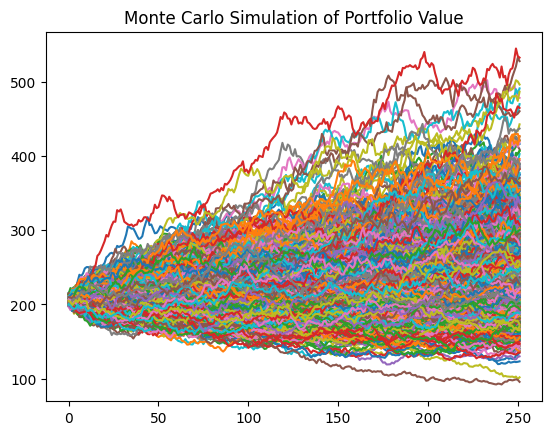

In [15]:
def MC(hist, mc, weights, time):  # Based on historical data simulates future portfolio returns, and therefore value
    # with Monte Carlo simulation
    MeanRmatrix = np.full(shape=(time, len(weights)), fill_value=hist[2]).T  # Matrix of mean daily returns
    sim_port = np.full(shape=(time, mc), fill_value=0.0)  # Sets up matrix for simulated portfolio value
    daily_return = np.full(shape=(time, mc), fill_value=0.0)  # Sets up matrix for simulated daily returns
    initialvalue = np.inner(weights, hist[4])  # Initial value of portfolio is the sumproduct of weights by last price
    for i in range(mc):
        """simulation with Cholesky-decomposition
        As the covariance matrix is positive definite, we can use the decomposition
        Returns of portfolio = Mean Returns + L * Z, where L is the Cholesky-decomposition form of covariance matrix, 
        and Z is a matrix of samples from normal distribution"""
        L = np.linalg.cholesky(hist[3])
        Z = np.random.normal(size=(time, len(weights)))
        sim_returns = MeanRmatrix + np.inner(L, Z)
        daily_return[:, i] = np.inner(weights, sim_returns.T)  # Simulates daily returns
        sim_port[:, i] = (1 + daily_return[:, i]).cumprod() * initialvalue  # Simulates daily value of portfolio
    port_return = (sim_port[-1] - initialvalue) / initialvalue  # Calculates overall return of portfolio
    return daily_return, port_return.mean(), sim_port  # Output is an array and a value

MCsimulation = MC(oneyeardata, 1000, weights, 252)  # We simulate the future of the portfolio
print(MCsimulation[1])
plt.plot(MCsimulation[2])
plt.title('Monte Carlo Simulation of Portfolio Value')

In [8]:
def VaR(returns, alfa):  # Value at risk from returns
    return np.percentile(returns, alfa)  # Output is the maximum percentile of loss with (1-alfa) significance level


def cVaR(returns, alfa):  # Conditional value at risk from returns
    condition = returns <= VaR(returns, alfa)
    return np.mean(returns[condition])  # Output is the mean percentile of loss beyond VaR cutoff point

In [16]:
# We calculate the VaR and cVaR of the portfolio for multiple intervals
# Different time intervals
time = {'3mo': 63, '1y': 1 * 252, '2y': 2 * 252, '5y': 5 * 252, '10y': 10 * 252}

# Gets data together by different time intervals
results = []
mcresults = []
for i in range(5):
    stockvalues = GetData(stocks, list(time.items())[i][0])
    portvalues = PortPerformance(weights, stockvalues[0], stockvalues[1], stockvalues[3])
    mcvalues = MC(stockvalues, 200, weights, list(time.items())[i][1])

    returns = portvalues[4]
    data = [list(time.items())[i][0], weights]
    data.extend([portvalues[0], portvalues[1], portvalues[2], portvalues[3]])
    data.extend([VaR(returns, alfa=5), cVaR(returns, alfa=5), VaR(returns, alfa=10), cVaR(returns, alfa=10)])
    results.append(data)

    mcdata = []
    values = pd.Series(mcvalues[0][-1, :])
    mcdata.append(list(time.items())[i][0])
    mcdata.extend([mcvalues[1], values.mean(), values.std(), values.min()])  # Standard deviation is returns related
    mcdata.extend([VaR(values, alfa=5), cVaR(values, alfa=5), VaR(values, alfa=10), cVaR(values, alfa=10)])
    mcresults.append(mcdata)

# Print in DataFrame format
with pd.option_context('display.max_columns', None):
    print(pd.DataFrame(results,
                       columns=['Historical Data', 'Weights', 'Return', 'Mean Return', 'Deviation', 'Max Drawdown', 
                                'VaR 5%',
                                'cVaR 5%', 'VaR 10%', 'cVaR 10%']),)
    print(pd.DataFrame(mcresults,
                       columns=['MC Data', 'Return', 'Mean Return', 'Deviation', 'Max Drawdown', 'VaR 5%', 'cVaR 5%',
                                'VaR 10%', 'cVaR 10%']))

[*********************100%***********************]  3 of 3 completed


C:\Users\Pinter Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
  Historical Data             Weights    Return  Mean Return  Deviation  \
0             3mo  [0.26, 0.57, 0.18]  0.000000    -0.001167   0.013982   
1              1y  [0.26, 0.57, 0.18] -1.654694     0.000723   0.014782   
2              2y  [0.26, 0.57, 0.18] -1.190360     0.000565   0.017962   
3              5y  [0.26, 0.57, 0.18]  0.394237     0.000741   0.018783   
4             10y  [0.26, 0.57, 0.18]  1.860536     0.000802   0.016623   

   Max Drawdown    VaR 5%   cVaR 5%   VaR 10%  cVaR 10%  
0     -0.043944 -0.027343 -0.038994 -0.018556 -0.031553  
1     -0.066438 -0.023153 -0.035401 -0.017809 -0.027531  
2     -0.079965 -0.026583 -0.041052 -0.020123 -0.032487  
3     -0.113552 -0.031772 -0.044778 -0.02

In [ ]:
# We can see the results in the tables above